### Reduced number of columns by dropping individual features of players

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html
import time

In [2]:
df_train = pd.read_pickle("./train_features_2.pkl")
df_test = pd.read_pickle("./test_features_2.pkl")

In [3]:
df_train.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,658,4,0,3,10,15,7,2,0,7,...,0.8,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [5]:
PATH_TO_DATA = '../../data/dota_2/'
SEED = 17

In [6]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

In [25]:
columns = list(df_train.columns)
print(columns)

['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_hero_id', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_hero_id', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r3_lh', 'r3_xp', 'r3_health', 'r3_max_health', 'r3_max_mana', 'r3_level', 'r3_x', 'r3_y', 'r3_stuns', 'r3_creep

In [11]:
columns.index('r1_kills')

6

In [12]:
columns.index('d5_sen_placed')

244

In [26]:
individual_columns = df_train.iloc[: , 5 : 245].columns
print(individual_columns)

Index(['r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=240)


In [27]:
X = df_train.drop(columns = individual_columns, axis = 1, )

In [28]:
X.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r_total_kills', 'd_total_kills', 'total_kills_ratio', 'r_std_kills',
       'd_std_kills',
       ...
       'mean_obs_placed_ratio', 'r_total_sen_placed', 'd_total_sen_placed',
       'total_sen_placed_ratio', 'r_std_sen_placed', 'd_std_sen_placed',
       'std_sen_placed_ratio', 'r_mean_sen_placed', 'd_mean_sen_placed',
       'mean_sen_placed_ratio'],
      dtype='object', length=212)

In [29]:
X_test = df_test.drop(columns = individual_columns, axis = 1 )
X_test.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r_total_kills', 'd_total_kills', 'total_kills_ratio', 'r_std_kills',
       'd_std_kills',
       ...
       'mean_obs_placed_ratio', 'r_total_sen_placed', 'd_total_sen_placed',
       'total_sen_placed_ratio', 'r_std_sen_placed', 'd_std_sen_placed',
       'std_sen_placed_ratio', 'r_mean_sen_placed', 'd_mean_sen_placed',
       'mean_sen_placed_ratio'],
      dtype='object', length=212)

In [30]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [31]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [32]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [33]:
import  time

Fold 0 started at Fri Nov 15 15:52:27 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.875141	valid_1's auc: 0.824495
Early stopping, best iteration is:
[1052]	training's auc: 0.877457	valid_1's auc: 0.82455
Fold 1 started at Fri Nov 15 15:52:36 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.876843	valid_1's auc: 0.812743
[2000]	training's auc: 0.915354	valid_1's auc: 0.81321
Early stopping, best iteration is:
[1849]	training's auc: 0.910262	valid_1's auc: 0.813265
Fold 2 started at Fri Nov 15 15:52:52 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.874462	valid_1's auc: 0.826844
Early stopping, best iteration is:
[1412]	training's auc: 0.892557	valid_1's auc: 0.8272
Fold 3 started at Fri Nov 15 15:53:04 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.874165	valid_1's auc: 0.827473
[2000]	training's auc: 0.913887

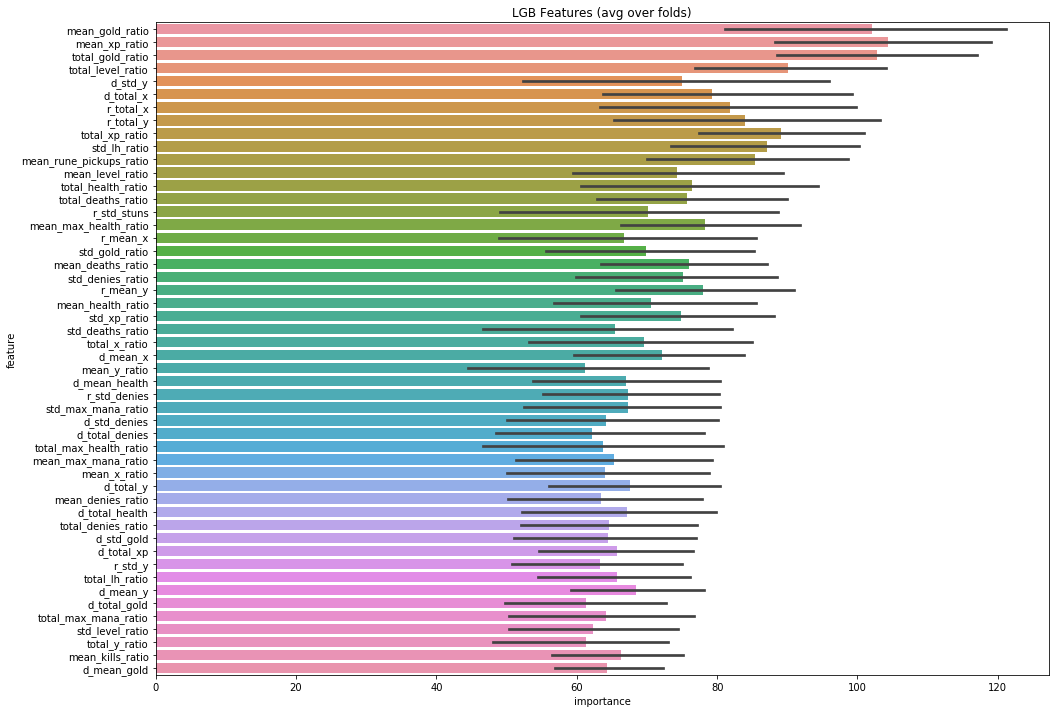

In [34]:
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

In [38]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [39]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f3.csv')

In [40]:
df_submission.head(3)

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.511747
70e5ba30f367cea48793b9003fab9d38,0.983812
4d9ef74d3a2025d79e9423105fd73d41,0.980381


In [41]:
pd.to_pickle(X, "./train_features_3.pkl")
pd.to_pickle(X_test, "./test_features_3.pkl")